In [72]:
import pandas as pd
import numpy as np
from pgmpy.models import BayesianModel
from pgmpy.estimators import HillClimbSearch, BicScore, MaximumLikelihoodEstimator
import networkx as nx
import matplotlib.pyplot as plt


In [73]:
# Load the dataset
# data = pd.read_csv('adult.csv') #'list_attr_celeba.txt') #'adult.csv')

data = pd.read_csv('list_attr_celeba.txt', sep='\s+', engine='python', skiprows=1)

# Preprocessing steps might include encoding categorical variables,
# handling missing values, etc. Here's a simple placeholder for preprocessing.
data.dropna(inplace=True)  # Example: Remove rows with missing values

# Assuming 'income' is the target variable and we want to predict this
# You might want to binarize or discretize some continuous variables for simplicity


In [74]:
(attribute_list)

['5_o_Clock_Shadow',
 'Arched_Eyebrows',
 'Attractive',
 'Bags_Under_Eyes',
 'Bald',
 'Bangs',
 'Big_Lips',
 'Big_Nose',
 'Black_Hair',
 'Blond_Hair',
 'Blurry',
 'Brown_Hair',
 'Bushy_Eyebrows',
 'Chubby',
 'Double_Chin',
 'Eyeglasses',
 'Goatee',
 'Gray_Hair',
 'Heavy_Makeup',
 'High_Cheekbones',
 'Male',
 'Mouth_Slightly_Open',
 'Mustache',
 'Narrow_Eyes',
 'No_Beard',
 'Oval_Face',
 'Pale_Skin',
 'Pointy_Nose',
 'Receding_Hairline',
 'Rosy_Cheeks',
 'Sideburns',
 'Smiling',
 'Straight_Hair',
 'Wavy_Hair',
 'Wearing_Earrings',
 'Wearing_Hat',
 'Wearing_Lipstick',
 'Wearing_Necklace',
 'Wearing_Necktie',
 'Young']

In [75]:
import random

attribute_list = list(data.columns)
priority_dict = {}

for i in attribute_list:
    priority_dict[i] = 1 # random.randint(1,10)/10
print(priority_dict)

# priority_dict = {"Young": 2, "Male": 5}
priority_dict_keys = priority_dict.keys()

black_list = []
for i in attribute_list:
    for j in attribute_list:
        if i == j:
            continue
        if i not in priority_dict_keys:
            i_priority = 1
        else:
            i_priority = priority_dict[i]

        if j not in priority_dict_keys:
            j_priority = 1
        else:
            j_priority = priority_dict[j]
        
        if i_priority < j_priority:
            black_list.append((i, j))

print(len(black_list), black_list)

{'5_o_Clock_Shadow': 1, 'Arched_Eyebrows': 1, 'Attractive': 1, 'Bags_Under_Eyes': 1, 'Bald': 1, 'Bangs': 1, 'Big_Lips': 1, 'Big_Nose': 1, 'Black_Hair': 1, 'Blond_Hair': 1, 'Blurry': 1, 'Brown_Hair': 1, 'Bushy_Eyebrows': 1, 'Chubby': 1, 'Double_Chin': 1, 'Eyeglasses': 1, 'Goatee': 1, 'Gray_Hair': 1, 'Heavy_Makeup': 1, 'High_Cheekbones': 1, 'Male': 1, 'Mouth_Slightly_Open': 1, 'Mustache': 1, 'Narrow_Eyes': 1, 'No_Beard': 1, 'Oval_Face': 1, 'Pale_Skin': 1, 'Pointy_Nose': 1, 'Receding_Hairline': 1, 'Rosy_Cheeks': 1, 'Sideburns': 1, 'Smiling': 1, 'Straight_Hair': 1, 'Wavy_Hair': 1, 'Wearing_Earrings': 1, 'Wearing_Hat': 1, 'Wearing_Lipstick': 1, 'Wearing_Necklace': 1, 'Wearing_Necktie': 1, 'Young': 1}
0 []


In [76]:
# Use Hill Climbing algorithm with BIC (Bayesian Information Criterion) as scoring method
hc = HillClimbSearch(data)

# Estimate the best model
best_model = hc.estimate(scoring_method=BicScore(data), max_iter=1000000, black_list=black_list)
print("Best model structure: ", best_model.edges())


  0%|          | 0/1000000 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# Define the model with the learned structure
model = BayesianModel(best_model.edges())

# Learn the parameters using Maximum Likelihood Estimation
model.fit(data, estimator=MaximumLikelihoodEstimator)


In [ ]:
def get_level_value(node, nodes_weight_dict, parent_node_dict):
    if len(parent_node_dict[node]) == 0:
        nodes_weight_dict[node] = 0
        return 0
    elif nodes_weight_dict[node] != -1:
        return nodes_weight_dict[node]
    else:
        max_weight = -1
        for i in parent_node_dict[node]:
            val = get_level_value(i, nodes_weight_dict, parent_node_dict)
            if max_weight < val:
                max_weight = val
        nodes_weight_dict[node] = max_weight + 1
        return max_weight + 1

nodes_weight_dict = {}
parent_node_dict = {}

for i in attribute_list: #list(model.nodes()):
    nodes_weight_dict[i] = -1
    parent_node_dict[i] = []

for i in list(model.edges()):
    parents = parent_node_dict[i[0]]
    if i[1] not in parents:
        parent_node_dict[i[0]].append(i[1])

for i in attribute_list:
    get_level_value(i, nodes_weight_dict, parent_node_dict)

print(len(nodes_weight_dict))
print(len(parent_node_dict))

40
40


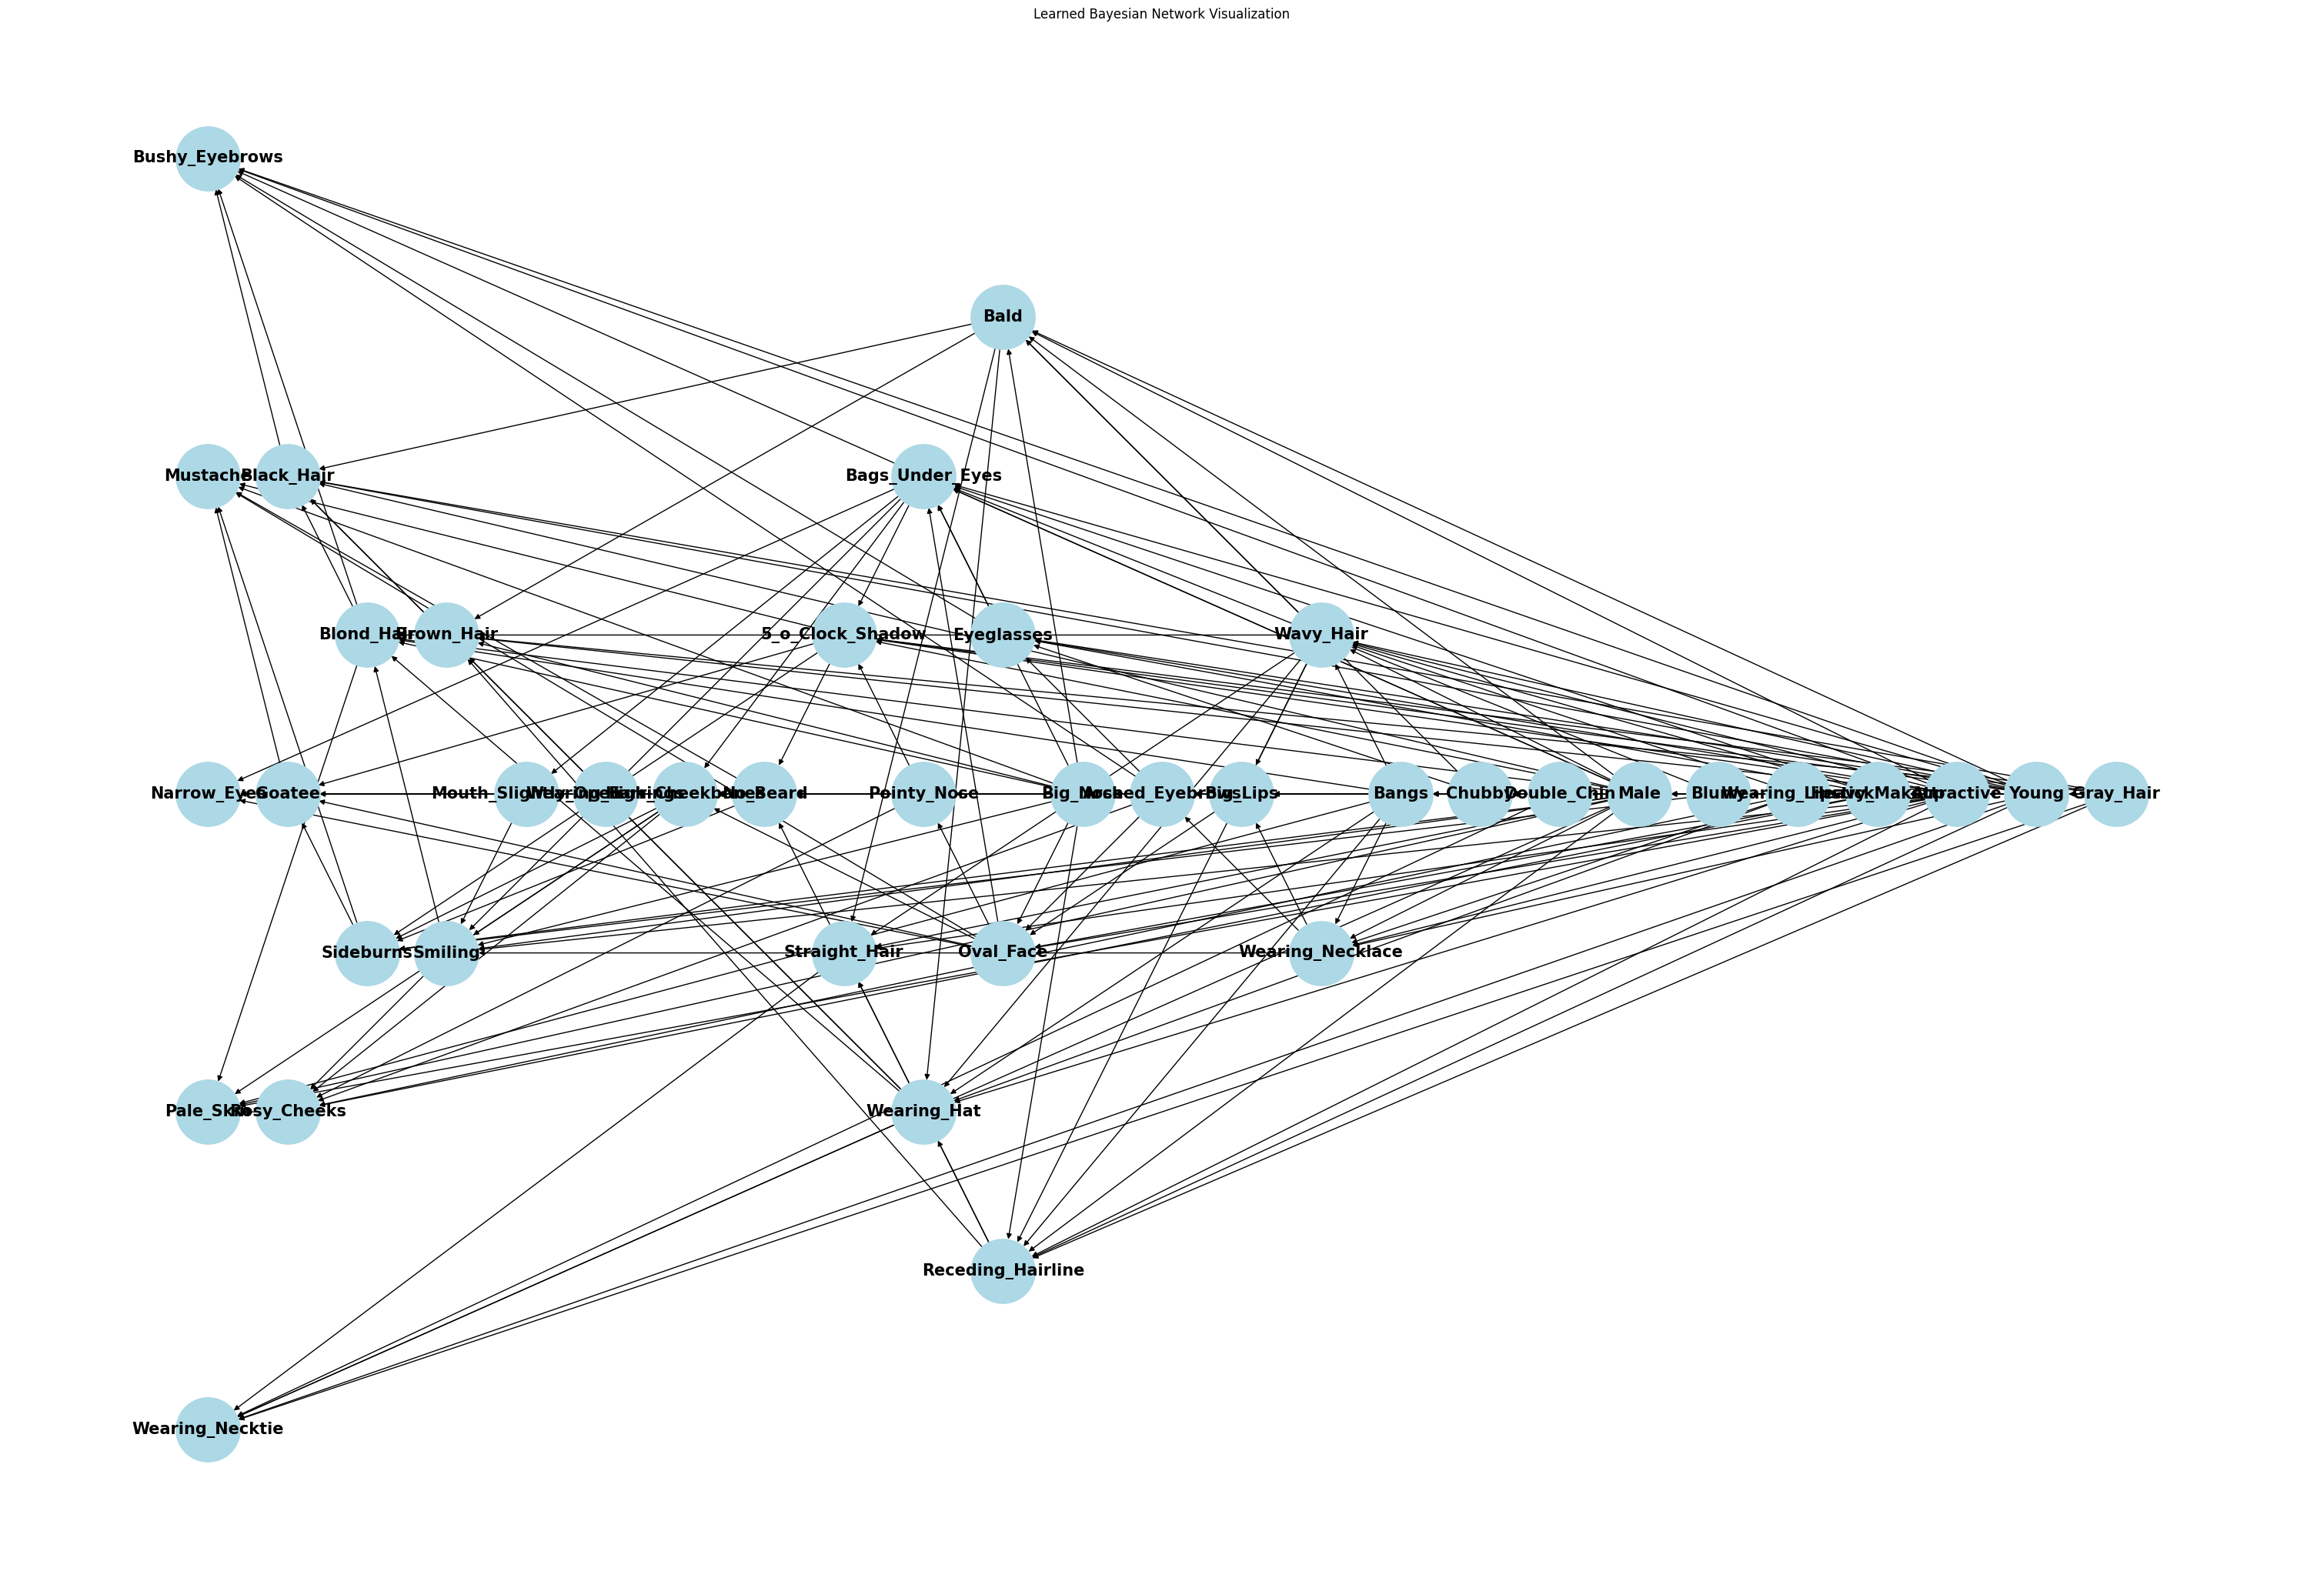

In [ ]:


fig = plt.figure(figsize=(30,20))
def visualize_model(model):
    G = nx.DiGraph()
    for i in attribute_list: #list(model.nodes()):
       G.add_node(i, level=nodes_weight_dict[i]) 

    G.add_edges_from(model.edges())
    
    pos = nx.layout.multipartite_layout(G, subset_key="level")
    nx.draw(G, pos, with_labels=True, node_size=3600, node_color="lightblue", font_size=15, font_weight="bold")
    plt.title("Learned Bayesian Network Visualization")
    plt.show()

visualize_model(model)


In [ ]:
for i in model.edges():
    print(i)

('5_o_Clock_Shadow', 'No_Beard')
('5_o_Clock_Shadow', 'Goatee')
('5_o_Clock_Shadow', 'Mustache')
('5_o_Clock_Shadow', 'Sideburns')
('No_Beard', 'Goatee')
('No_Beard', 'Sideburns')
('No_Beard', 'Mustache')
('No_Beard', 'High_Cheekbones')
('Goatee', 'Mustache')
('Sideburns', 'Goatee')
('Sideburns', 'Mustache')
('Arched_Eyebrows', 'Wearing_Earrings')
('Arched_Eyebrows', 'Oval_Face')
('Arched_Eyebrows', 'Bushy_Eyebrows')
('Arched_Eyebrows', 'Eyeglasses')
('Arched_Eyebrows', 'Rosy_Cheeks')
('Arched_Eyebrows', 'Big_Nose')
('Wearing_Earrings', 'Mouth_Slightly_Open')
('Oval_Face', 'Narrow_Eyes')
('Oval_Face', 'High_Cheekbones')
('Oval_Face', 'Smiling')
('Oval_Face', 'Bags_Under_Eyes')
('Oval_Face', 'Pointy_Nose')
('Oval_Face', 'Mustache')
('Oval_Face', 'Goatee')
('Eyeglasses', 'Bags_Under_Eyes')
('Eyeglasses', 'Bushy_Eyebrows')
('Rosy_Cheeks', 'Pale_Skin')
('Big_Nose', 'Bags_Under_Eyes')
('Big_Nose', 'Receding_Hairline')
('Big_Nose', 'Brown_Hair')
('Big_Nose', 'High_Cheekbones')
('Big_Nose', '

In [ ]:
len(model.edges())

219

In [ ]:
import pandas as pd
from numpy.random import choice
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, HillClimbSearch
from pgmpy.inference import VariableElimination

# Generate a synthetic dataset
data = pd.DataFrame({
    'Fever': choice(['high', 'low'], size=500, p=[0.6, 0.4]),
    'Cough': choice(['present', 'absent'], size=500, p=[0.7, 0.3]),
    'Fatigue': choice(['present', 'absent'], size=500, p=[0.8, 0.2]),
    'MusclePain': choice(['present', 'absent'], size=500, p=[0.5, 0.5]),
    'Disease': choice(['cold', 'flu', 'other'], size=500, p=[0.5, 0.3, 0.2])
})

# Structure Learning
model = BayesianNetwork()
est = HillClimbSearch(data)
best_model = est.estimate()
print("Learned Structure:")
print(best_model.edges()) 

# Parameter Learning
mle = MaximumLikelihoodEstimator(model, data)
mle.estimate_cpds()  

# Inference
infer = VariableElimination(model)
result = infer.query(['Disease'], evidence={
    'Fever': 'high', 'Cough': 'present', 'MusclePain': 'absent'
})
print("Inference Result:")
print(result['Disease'])


  0%|          | 0/1000000 [00:00<?, ?it/s]

Learned Structure:
[]


AttributeError: 'MaximumLikelihoodEstimator' object has no attribute 'estimate_cpds'